# Projekt 3 - Infravörös távolság mérés threadinggel

Ha jól megfigyeltétek az eddigi projektjeinket akkor láttátok, hogy az általunk írt kódok sorrendben hajtják végre az utasításokat. Legtöbbször van egy végtelen ciklus, amiben a fő parancsokat végrehajtatjuk, pl. kiolvasni a fotodiódán mért feszültséget. A hátránya ennek a módszernek, hogy emellett más folyamatot nem tudunk végrehajtani.

A DC motorok tesztelésénél láthattuk, hogy amikor a terminálból kiadtuk a motornak parancsba, hogy forogjon, az elkezdett forogni és visszakaptuk a terminál fölött az irányítást. A legtöbb esetben, ha mérni vagy vezérelni szeretnénk valamit, örülnénk, ha nem kellene megvárni az irányítás visszanyerésére azt, hogy az elindított folyamat befejeződjön.

Pythonban erre használható a ```threading```. Ez lehetővé teszi, hogy két parancs egymástól függetlenül, "párhuzamosan" fusson. A valóságban a ```threading``` nem igazi párhuzamos parancs végrehajtás, de egyszerű körülmények között annak tűnhet. 

Ebben a projektben a távolság mérést egy függvénybe kódoljuk bele és a ```threading``` segítségével elindítjuk és hagyjuk mérni a háttérben, miközben nem veszítjük el a terminál feletti kontrolunkat. 

## Mit fogsz készíteni?

Az elrendezésünk elsősorban egy IR forrásból (LED) és egy szenzorból fog állni, a hozzájuk tartozó ellenállásokkal együtt. A jel digitalizálására egy MCP3008-as ADC-t használunk. Másodsorban bemutatjuk, hogyan lehet a mért jelet felerősíteni a volt tartományba egy LM358-as operációs erősítő és a hozzá tartozó ellenállások segítségével. 

## Mit tanulsz meg?

Az infravörös szenzor elkészítésével a következőket tanulod meg:

* Hogyan működik az IR szenzor, hogyan digitalizáljuk az analóg jelet és olvassuk ki azt Pythonból.
* Hogyan inicializáljunk egy IR LED-et és MCP3008 ADC-t.
* Hogyan kapcsoljuk ki- és be az IR LED-et és hogyan olvassuk ki a szenzor feszültségét az ADC-n keresztül.
* Hogyan olvassunk be fájlokat és nyerjük ki belőle az információt.
* Hogyan kell interpolálni.
* Mi az az ```event```?
* Hogyan kell függvényeket elindítani a ```threading``` segítségével.

## A projekt részletekre bontása

* Elkészíteni az áramkört.
* Beimportálni és inicializálni a ```LED``` és ```MCP3008``` objektumokat.
* Beolvasni a feszültséget távolsággá alakító referencia fájlt.
* Definiálni egy függvényt ami folytonosan kiolvassa az ADC-ből a szenzor által mért feszültséget, majd megbecsüli (interpolálja) a távolságot és kinyomtatja a távolságot a képernyőre.
* Definiálunk egy függvényt, ami létrehoz egy eseményt ami leállítja a háttérben futó mérést.

## Áramköri elemek listája

a) [Raspberry PI](https://malnapc.hu/yis/raspberry-pi/rpi-panelek) 

b) IR LED, 940 nm: [itt vásárolhatsz](https://www.tme.eu/hu/details/lte-4206/ir-led-ek/liteon/)

c) IR szenzor, 940 nm: [itt vásárolhatsz](https://www.tme.eu/hu/details/bpv10nf/fotodiodak/vishay/)

d) [Jumper wires female/male](https://www.ret.hu/shop/product/e-call/jumper-vezetek-szet_53-22-63) 

e) Ellenállás: [itt vásárolhatsz](https://www.tme.eu/hu/katalog/metal-film-tht-ellenallasok_112313/?s_order=desc&search=ellenallas&s_field=1000011)

f) [MCP3008 ADC](https://www.tme.eu/hu/details/mcp3008-i_p/a-d-konverterek-ic-k/microchip-technology/)

g) [LM358 operációs erősítő](https://www.tme.eu/hu/details/lm358n_nopb/tht-muveleti-erositok/texas-instruments/)

## A kapcsolási rajz

<img src="bevezeto/prog01_schema.png" width=600 height=400 />

A fenti ábrához hasonlóan kapcsoljuk össze az áramköri elemeket és a Raspberry Pi-t.

1) Kössük össze a Raspberry Pi egyik földelését az MCP3008 AGND ás DGND lábaival (fekete drót).

2) Kössük az MCP3008 *VDD* és *VREF* nevű lábait a Raspberry Pi 3.3 V-os tüskéjére. 

3) Kössük az MCP3008 *CLK* nevű lábát a Raspberry Pi *GPIO11* tüskéjére. 

4) Kössük az MCP3008 *DOUT* nevű lábát a Raspberry Pi *GPIO09* tüskéjére. 

5) Kössük az MCP3008 *DIN* nevű lábát a Raspberry Pi *GPIO10* tüskéjére.

6) Kössük az MCP3008 *CS* nevű lábát a Raspberry Pi *GPIO08* tüskéjére.

7) Az LM358 erősítő 8-as lábát kössük a Raspberry Pi 3.3 V-os tüskéjére.

8) Az LM358 erősítő 4-es és 3-as (nem invertáló) lábát kössük a földelésre (GND) tüskéjére.

9) A fotodióda anódját (pozitív, hosszabb láb) kössük szintén a földelésre.

10) A fotodióda katódját (negatív, rövidebb láb) kössük az LM358 erősítő 2-es (invertáló) lábára.

11) Az LM358 erősítő 2-es (invertáló) és 1-es (kimenet) lába közéiktassunk be egy R1 = 1 MOhmos ellenállást.

12) Az LM358 erősítő 1-es (kimenet) lábát kössük át a másik oldalon elhelyezkedő erősítő sorának 5-ös (nem invertáló) lábára.

13) Az LM358 erősítő 6-os lába (invertáló) és a földelés (GND) közé kössünk be az R2 = 1 kOhm ellenállást.

14) Az LM358 erősítő 6-os lába (invertáló) és a 7-es (kimenet) lába közé kössünk be az R3 = 10 kOhm ellenállást. Az R2 és R3 ellenállások ilyen választásával 11-szeres erősítést érhetünk el a jelen.

15) Az IR LED anódját (pozitív, hosszabb láb) kössük a Raspberry Pi *GPIO02*-es tüskéjére, míg a katódját (negatív, rövidebb láb) kössük sorba egy 200 Ohmos ellenállással.

16) A 200 Ohmos ellenállás másik lábát kössük a földelésre (GND).

## A kód

Nyissunk meg egy új python fájlt és mentsük el pl. ```ir_threading.py``` név alatt. A ```gpiozero``` csomagnak nincs beépített objektuma ami általánosan az IR szenzort tudná kezelni, így mi fogjuk megoldani a szenzorral való kommunikációt.

### A segédfüggvények

Ahhoz, hogy a szenzor által mért feszültséget távolság formájában tudjuk megjeleníteni, szükségünk lesz egy fájlra, ```ir_calibration.csv```, amit előre elkészítünk, és tartalmazza a mért feszültségeket és a hozzá tartozó kimért távolságokat, vesszővel elválasztva. Ha elkészítettük ezt a kalobrációs fájlt, mentsük le az előbb említett név alatt ugyanabba a mappába, ahova a kódot is lementjük. 

A fő kódban, szükségünk lesz egy függvényre, ```read_2column_files```, amivel be tudjuk olvasni a kalibrációs fájl tartalmát. Ezt a függvényt a ```raspberry_functions.py``` fájlba mentjük el, majd importáljuk a fő programba. Ennek a függvénynek 3 bemenő paramétere van, a ```name``` a fájl neve (vagy abszolút/relatív útvonalat is tartalamzó név), a ```sep``` ami az adatelválasztó karaktert adja meg (általában a ```','```) és végül a ```header``` amivel megadhatjuk, hogy a fájlnak van-e (```True```) fejléce vagy nincs (```False```). Ez a függvény támaszkodik egy másikra is, ```read_temp_raw```, ami a fájlnév alapján vissza adja annak sorait egy listában. 

```raspberry_functions.py```:

In [2]:
# Ez a fuggeny csak beolvassa a fajl tartalmat es annak sorait
# egy lista elemeive alakitva azt visszaadja
def read_temp_raw(file_name):
    f = open(file_name, 'r')
    lines = f.readlines()
    f.close()
    return lines

# A read_2column_files beolvassa a ket oszlopos csv fajlt, es annak oszlopait
# kimenti ket numpy arraybe
def read_2column_files(name, sep=',', header=True): 
    lines = read_temp_raw(name)   # listaba olvasni a fajl sorait
    if header:                    # ha van fejlec azt eltavolitani
        lines.pop(0)
    distance = []                 # lista inicializalas a tavolsagok tarolasara
    voltage = []                  # lista inicializalas a feszultsegek tarolasara
    for line in lines:            # vegig lepni az osszes soron
        if line.strip() != '':    # ha a kiolvasott sor nem ures
            # szetvalasztani a sort a sep valtozo menten pl. sep=','. 
            # Az igy kapott ket elemet a data valtozoba menteni
            data = line.strip().split(sep)   
            voltage.append(float(data[0]))   # a data elso elemet adjuk a feszultseg listahoz szamma alakitva, float
            distance.append(float(data[1]))  # a data masodik elemet adjuk a tavolsag listahoz szamma alakitva, float
    return np.array(voltage), np.array(distance) # adjuk vissza a ket listat numpy array-e alakitva


A ```read_2column_files``` először beolvassa a megadott fájl tartalmát egy listába, majd megviszgálja, hogy van-e fejléc. Ha igen, akkor azt eltávolítja a listából, ```lines.pop(0)```. Ezután létrehozunk két üres listát a távolságok és a hozzá tartozó feszültségek tárolására. Majd végig lépkedünk a fájl sorait tartalmazó listán ```for line in lines:```. Mielőtt kinyernénk a sorokból a számokat, megnézzük, hogy van-e egyáltalán a sorban valamilyen információ, ```if line.strip() != '':```. Ha a sor nem üres, akkor a két részre választjuk a megadott szeparátor mentén, ```data = line.strip().split(sep)```. Az így kapott lista első elemét a ```voltage``` listához adjuk, miután a sztring formátumot számmá alakítottuk a ```float``` paranccsal. Ugyanezt megtesszük a második elemmel is, csak azt a ```distance``` listához adjuk hozzá. Végül visszaadjuk a két listát miután ```numpy``` array-é alakítottuk.

### Távolság interpolálás

Az ADC konverteren nem feltétlenül mérünk majd olyan feszültségeket, amik a kalibrációs táblázatunkban szerepelnek, így interpolálnunk kell majd.

#### Interpolálás

Az interpoláció matematikai közelítő módszer, amely egy függvény nem ismert értékeire az ismert értékek alapján ad közelítést. Pythonban a ```scipy.interpolate``` csomagból az ```interp1d``` függvényt használjuk, aminél három bemenő paraméter van, a) az új érték(ek) aminél szeretnénk kivizsgálni a függvényt, b) az ismert *x* értékek és a c) hozzá tartozó ismert *y* értékek. 

Példaként definiáljunk egy parabolát 11 megadott pontban, majd keressük meg a parabola értéket egy új eddig nem használt pontban:

In [18]:
from scipy.interpolate import interp1d
x = np.array([-5,-4,-3,-2,-1,0,1,2,3,4,5])
y = 2*x**2 - 8*x + 3
print(y)

[93 67 45 27 13  3 -3 -5 -3  3 13]


Felhasználva az ```interp1d``` függvényt az lineáris összefüggést feltételezve az egymást követő pontok között megbecsüli, hogy két definiált közötti új pontnál milyen értéket vesz fel a függvény. Az ```f = interp1d(x, y)``` kifejezés egy függvényt hoz létre, aminek új *x* paramétereket adva kiszámolja, hogy az új helyeken mekkora a függvény értéke. 

Interpoláláshoz meg kell adnunk új értékeket ```new_x```, amelyekhez tartozó parabolaértékekre kíváncsiak vagyunk. 

In [19]:
f = interp1d(x, y)
new_x = np.array([-1.5, 3.5])
f(new_x)

array([20.,  0.])

Szemléltetés miatt, lejjebb bemutatjuk, hogy néz ki az eredeti parabola (kék vonal) és a megbecsült új *x* értékekhez tartozó *y* értékek (piros pontok). Amint láthatjuk, a piros pontok szépen illeszkednek a kék vonalhoz, azaz jó becslést adnak.

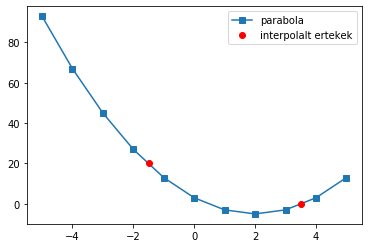

In [33]:
import matplotlib.pyplot as plt

plt.plot(x,y, 's-', label='parabola')
plt.plot(new_x, f(new_x), 'or', label = 'interpolalt ertekek')
plt.legend()

Az a módszer főleg akkor alkalmazható biztonságosan, ha az eredeti *x* értékek elég közel állnak egymáshoz, azaz a függvény folytonossága nem nagyon törik meg. 

#### Interpolálás függvény

Az újrafelhasználhatóság végett, az interpolálás függvényt is a ```raspberry_functions.py``` fájlba mentjük el, ahonnan majd beimportáljuk a fő programba. Az ```interpolate1d``` nevű függvény három bemenő paramétert vár, az ismert *x* és az *y* értékeket valamint a ```target```, új *x* értékeket, ahol még nem ismert a függvény értéke. A visszaadott érték pedig nem más mint az új *x* értékekhez tartozó *y* értékek. A ```target``` lehet egy szám vagy akár egy numpy array is.

```raspberry_functions.py```:

In [4]:
def interpolate1d(x, y, target):
    f = interp1d(x,y)
    return f(target)

### Az IR LED tesztelése

Az infravörös szenzorunk teszteléséhez először be kell importálnunk a ```LED``` és ```MCP3008``` objektumokat. Ezenfelül, beimportáljuk a ```read_2column_files``` és az ```interpolate1d``` függvényeket is a ```raspberry_functions``` modulból. A modul legyen ugyanabban a mappában, mint a fő kódunk. 

```ir_threading.py```:

In [1]:
from gpiozero import LED, MCP3008
from raspberry_functions import read_2column_files, interpolate1d

A következő lépés letesztelni, hogy sikerül-e kommunikálni az IR LED-del. Ez a LED is pont ugyanolyan, mint a látható tartományban működő társai, így az inicializálása is ugyanúgy működik.

Az inicializálás után próbáljuk ki az ```.on(), .off(), .blink()``` metódusokat. Sajnos szabad szemmel semmi változást nem fogunk látni a LED-en, de a mobiltelefonunk kameráját a LED-re irányítva már nagyobb sikerünk lehet. Ha megjelenik, egy rózsaszínes folt a LED képén bekapcsoláskor, akkor működik a vezérlés.

```ir_threading.py```:

In [ ]:
from gpiozero import LED, MCP3008

# inicializaljunk egy LEDet

ir = LED(2)

# teszteljuk, ki be kapcsolassal, villogassal a mukodeset
ir.on()
ir.off()
ir.blink()
ir.off()

### Az IR szenzor tesztelése

Ezek után letesztelhetjük a fotodiódát is. Mivel az analóg jelet ad, azt egy ADC konverterre kellett kötnünk, hogy a Raspberry ki tudja a feszültséget olvasni. Mi itt a 8 csatornás 10 bites konvertert inicializáljuk, ```mcp = MCP3008(channel=7)```. A ```mcp.voltage``` változó meghívásával ki tudjuk olvasni az aktuálisan mért feszültséget. Alapjáraton nem kellene feszültséget mérnie, azaz 0 közeli értéket kellene mutatnia. Viszont, ha az IR LED-et rá irányítjuk, akkor a kiolvasott feszültségnek növekednie kell. Sőt a sima lámpafényt, napfényt vagy kisebb hatásfokkal a mobil flash lámpáját is ráirányíthatjuk. Ezek mindegyike tartalmaz kisebb-nagyobb mértékben infravörös jelet, amit a fotodióda mérhet. 

```ir_threading.py```:

In [ ]:
from gpiozero import LED, MCP3008

# inicializaljunk egy LEDet

ir = LED(2)
mcp = MCP3008(channel=7)

# teszteljuk, ki be kapcsolassal, villogassal a mukodeset
ir.on()

print(mcp.voltage)

### A threading

In [5]:
from time import sleep, perf_counter

def task(id):
    print(f'Az {id} feladat inditasa...')
    sleep(1)
    print('kesz')


start_time = perf_counter()

for n in range(1, 11):
    task(n)


end_time = perf_counter()

print(f'{end_time- start_time: 0.2f} masodpercbe telt befejezni.')

Az 1 feladat inditasa...
kesz
Az 2 feladat inditasa...
kesz
Az 3 feladat inditasa...
kesz
Az 4 feladat inditasa...
kesz
Az 5 feladat inditasa...
kesz
Az 6 feladat inditasa...
kesz
Az 7 feladat inditasa...
kesz
Az 8 feladat inditasa...
kesz
Az 9 feladat inditasa...
kesz
Az 10 feladat inditasa...
kesz
 10.12 masodpercbe telt befejezni.


In [3]:
import threading


def task(id):
    print(f'Az {id} feladat inditasa...')
    sleep(1)
    print('kesz')


start_time = perf_counter()

# create and start 10 threads
threads = []
for n in range(1, 11):
    t = threading.Thread(target=task, args=(n,))
    threads.append(t)
    t.start()

# wait for the threads to complete
for t in threads:
    t.join()

end_time = perf_counter()

print(f'{end_time- start_time: 0.2f} masodpercbe telt befejezni.')

Az 1 feladat inditasa...Az 2 feladat inditasa...

Az 3 feladat inditasa...
Az 4 feladat inditasa...
Az 5 feladat inditasa...
Az 6 feladat inditasa...Az 7 feladat inditasa...
Az 8 feladat inditasa...

Az 9 feladat inditasa...
Az 10 feladat inditasa...
keszkesz

keszkesz
kesz

keszkeszkeszkesz



kesz
 1.06 masodpercbe telt befejezni.


#### A ```start``` függvény a mérés threadingben indítására

In [1]:
def start(event):
	print('Measurement started')
	while not event.is_set():
		current_voltage = mcp.voltage
		current_distance = interpolate1d(volt, distance, current_voltage)
		print(f'Current distance from object is: {current_distance:.2} cm')
		time.sleep(1)

#### A ```stop``` függvény a mérés threadingben megállítására

In [2]:
def stop(event):
	event.set()
	print('Measurement is stopped')

### A mért távolság lekódolása

Miután inicializáltuk és leteszteltük a szenzorunk működését, beolvassuk a kalibrációs fájl tartalmát. A ```calib_file``` változóba elmentjük a fájlunk nevét (figyeljünk oda, hogy legyen a fájl ugyanabban a mappában mint ez a kód). Ezután felhasználjuk a ```read_2column_files``` segédfüggvényt, hogy kiolvassuk a kalibrációs fájl tartalmát. A ```volt``` változóba tároljuk az előre lemért feszültségeket és a ```distance``` változóba a hozzájuk tartozó távolságokat. A függvény ```header``` paraméterét aszerint állítsuk be, hogy van-e fejléc vagy sem. 

Indítsunk el egy végtelen ```while``` ciklust, amiben folyamatosan kiolvassuk a szenzor által mért feszültségeket, ```current_voltage = mcp.voltage```. Az így kapott értéket adjuk bemenő paraméterként a kalibrációs értékek mellett az interpoláló függvénynek, ```current_distance = interpolate1d(volt, distance, current_voltage)```, hogy meghatározzuk, mekkora távolság tartozik a mért feszültséghez. Végül kiíratjuk a kapott távolságot a képernyőre, ```print(f'Current distance from object is: {current_distance:.2} cm')```. 

```ir_threading.py```:

In [51]:
import threading
import time
from gpiozero import LED, MCP3008
from raspberry_functions import read_2column_files, interpolate1d

ir = LED(2)
mcp = MCP3008(channel=7)

calib_file = 'ir_calibration.csv'
volt, distance = read_2column_files(calib_file, header=True)

def start(event):
	print('Measurement started')
	while not event.is_set():
		current_voltage = mcp.voltage
		current_distance = interpolate1d(volt, distance, current_voltage)
		print(f'Current distance from object is: {current_distance:.2} cm')
		time.sleep(1)
		
def stop(event):
	event.set()
	print('Measurement is stopped')
	

kill = threading.Event()
t = threading.Thread(target=start, args=(kill,))
t.start()
time.sleep(6)
stop(kill)
t.join()


Ha a program működik és fut, a ```CTRL+C``` billentyűpárral tudjuk leállítani.

## A projekt tesztelése

Miután összeszereltük az áramkört és a kódot is megírtuk, amit pl. ```ir_threading.py``` név alatt mentettünk el, megnyithatunk a Raspberry Pi operációs rendszerén egy terminált. A terminálban a ```cd 'mappa név'``` paranccsal elnavigálunk abba a mappába, ahova a ```ir_threading.py```-t elmentettük. Ott begépelve a ```python ir_threading.py``` parancsot, letesztelhetjük a programunk működését. Ha minden jól megy akkor a terminálból el tudjuk indítani a mérést úgy, hogy visszakapjuk a terminál felett az irányításunk.

Hibaüzenetek esetén ki kell deríteni mi lehetett a probléma, pl. elgépelés, egy modul hiányzik, sorok megfelelő behúzása, idézőjel lemaradása stb. A hibaüzenet legtöbbször segít abban, hogy melyik sorban találta a hibát és hogy mi volt az. Egy kis gyakorlással bele lehet jönni azok értelmezésébe, valamint interneten is rá lehet keresni a hibaüzenet jelentésére és annak lehetséges elhárítására.

## Mit lehet javítani/továbbfejleszteni?

* Módosítsuk a kódot úgy, hogy csak minden 10-ik ciklusban írja ki a távolságot.
* Módosítsuk a ```start``` függvényt, hogy elindítása után 10 másodperccel egy esemény leállítsa.

Írd meg kommentben, hogy szerinted mivel lehetne még feldobni ezt a kis programot!

## Referencia

1) gpiozero LED - https://gpiozero.readthedocs.io/en/stable/api_output.html#led

2) MCP3008 datasheet - https://cdn-shop.adafruit.com/datasheets/MCP3008.pdf

3) LM358 datasheet - https://www.ti.com/lit/ds/symlink/lm158-n.pdf , https://components101.com/ics/ic-lm358-pinout-details-datasheet

4) gpiozero MCP3008 - https://gpiozero.readthedocs.io/en/stable/api_spi.html

5) Fájlok kezelése - https://www.programiz.com/python-programming/file-operation

6) Interpolálás - https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html#scipy.interpolate.interp1d

7) threading - https://realpython.com/intro-to-python-threading/